# DATASET CREATION

_In this project we will learn about EDA , this is my first project in EDA and for it I will analyse the injuries of soccer players in europe_

_For this project I decide to create my own dataset and not to take a dataset from known website like kaggle and so ..
My dataset is built from data taken from two website :_
 * http://Transfermarket.com 
 * http://lequipe.fr <br>
 
_from Transfermarket I get all the info about players name, club, age and the most important injury history and from lequipe I get the weight of the players._

_This method is called Web scraping and for it we need to library:_
* requests
* BeautifulSoup

In [ ]:
import re
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pd.set_option('notebook_repr_html', True)

#### To get success response for my request to transfermarkt I need to join headers to my request 

In [ ]:
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
league = ['GB1','FR1','L1','IT1','ES1']
league_page = "https://www.transfermarkt.com/jumplist/startseite/wettbewerb/"

_I will describe the steps for building the dataset:_
* get all the clubs from the 5 best league in europe .
* For each club get all the players 
* For each player get the basic info and injury history


In [ ]:
def get_club_details(tr_tag):
    club = tr_tag.find_all('a',class_="vereinprofil_tooltip")[1]
    club_link = club['href']
    club_name = club.get_text()
    club_value = tr_tag.find_all('td',class_="rechts show-for-small show-for-pad nowrap")[0].get_text()
    return tuple((club_link,club_name,club_value))

In [ ]:
clubs_list = []
for league_id in league:
    page = requests.get(league_page + league_id,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('tbody')[1]
    tr_container = tbody_container.find_all('tr')
    for tr_tag in tr_container :
        clubs_list.append(get_club_details(tr_tag))
print('All the club were uploaded')
print(clubs_list)

In [ ]:
def get_players_club(player):
    player_id = player['id']
    player_link = player['href']
    player_name = player.get_text()
    return tuple((player_id,player_link,player_name,club_name,club_value))

In [ ]:
url_site = "https://www.transfermarkt.com"
player_list = []
for club_link,club_name,club_value in clubs_list:
    page = requests.get(url_site + club_link,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('tbody')[1]
    players_details = tbody_container.find_all('a',class_="spielprofil_tooltip")
    for player in players_details[::2] :
        player_list.append(get_players_club(player))
print('All the players were uploaded')
print(player_list)

In [ ]:
def get_profil_detail(soup):
    table_container = soup.find_all('table', class_="auflistung")[0]
    td_container = table_container.find_all('td')
    if td_container[1].find('a') == None:
        birth = td_container[0].find('a')['href'].split("/")[-1]# take it in format YYYY-MM-DD for datetime later
        height = td_container[3].get_text().split("m")[0]# I remove the m of meter 
        country = td_container[4].find('img')['title']
        role = td_container[5].get_text().strip()
        foot = td_container[6].get_text()
    else :
        birth = td_container[1].find('a')['href'].split("/")[-1]
        height = td_container[4].get_text().split("m")[0]# I remove the m of meter 
        country = td_container[5].find('img')['title']
        role = td_container[6].get_text().strip()
        foot = td_container[7].get_text()
    tbody_container = soup.find_all('tbody')[0]
    tr_transfer_container = tbody_container.find_all('tr',class_="zeile-transfer")
    transfer_list = []
    for tr_transfer_tag in tr_transfer_container:
        td_transfer_container = tr_transfer_tag.find_all("td")
        tranfer_from = td_transfer_container[5].get_text()
        transfer_to = td_transfer_container[9].get_text()
        transfer_season = td_transfer_container[0].get_text()
        transfer_date = td_transfer_container[1].get_text()
        transfer_list.append(tuple((tranfer_from,transfer_to,transfer_season,transfer_date)))
    return tuple((Id,name,club,club_value,birth,height,country,role,foot,link.split("/")[1],transfer_list))
        

In [ ]:
print(player_list)

In [ ]:
player_details = []
i=0
for Id,link,name,club,club_value in player_list:
    i=i+1
    if i%10 == 0:
        print("new league upload")
        if i == 40:
            print("break")
            break
    try:
        page = requests.get(url_site + link,headers = headers)
        soup = bs(page.content, 'html.parser')
        player_details.append(get_profil_detail(soup))
    except Exception as e:
        print("la")
        player_details.append(tuple((Id,name,club,club_value,None,None,None,None,None,link.split("/")[1],[])))
        continue
print("all player details uploaded")

### Code to retreive injury per season of each player

<img src="history_injurie.png">

In [ ]:
def get_injuries_details(soup):
    tbody_container = soup.find_all('tbody')[0]
    tr_container = tbody_container.find_all('tr')
    injuries_list = []
    for tr_tag in tr_container:
        season = tr_tag.find_all('td')[0]
        injury = tr_tag.find_all('td')[1]
        time_out = tr_tag.find_all('td')[4]
        injuries_list.append(tuple((season.get_text(),injury.get_text(),time_out.get_text().split()[0])))
    return injuries_list

In [ ]:
player_list = []
for Id,name,club,club_value,birth,height,country,role,foot,name_link,transfer_list in player_details:
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
        page = requests.get("https://www.transfermarkt.com/{}/verletzungen/spieler/{}".format(name_link,Id),headers=headers)
        soup = bs(page.content, 'html.parser')
        player_list.append(tuple((Id,name,club,club_value,birth,height,country,role,foot,transfer_list,get_injuries_details(soup))))
    except Exception as e:
        print("la")
        player_list.append(tuple((Id,name,club,club_value,birth,height,country,role,foot,transfer_list,[])))
        continue
print(player_list)
print("all player injuries details uploaded")
print("End of uploading from Transfermarkt")

_until here we get all the player infos from transfertmarkt  .Now ,we need to retreive for each player his weight , this info could be find in website http://lequipe.fr_

In [ ]:
def get_list_club_lequipe(h2_tag,league_id):
    if league_id == 'EQ_D1' :
        club = h2_tag.find_all('a')[1]
        club_link = club['href']
        club_name = club['title']
        return tuple((club_link,club_name))
    else:
        club = h2_tag.find('a')
        club_link = club['href']
        club_name = club['title']
        return tuple((club_link,club_name))

In [ ]:
league = ['EQ_ANG','EQ_D1','EQ_ALL','EQ_ITA','EQ_ESP']
league_page = "https://www.lequipe.fr/Football/"
clubs_list_lequipe = []
for league_id in league:
    print(league_id)
    page = requests.get(league_page + league_id + ".html",headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('div',class_="listeclubs")[0]
    h2_container = tbody_container.find_all('h2')
    for h2_tag in h2_container :
        clubs_list_lequipe.append(get_list_club_lequipe(h2_tag,league_id))
print('All the club were uploaded')

In [ ]:
url_site = "https://www.lequipe.fr"
player_list_lequipe = []
for club_link,club_name in clubs_list_lequipe:
    page = requests.get(url_site + club_link,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('table')[4]
    players_details = tbody_container.find_all('tr')
    for player in players_details[1:] :
        player_details = player.find_all('a')[0]
        weight = player.find_all('td')[6]
        player_name = player_details.get_text().strip()
        player_list_lequipe.append(tuple((player_name,club_name,weight.get_text())))
print("all player from lequipe were uploaded")

In [ ]:
club_to_player_map = {}
for player in player_list_lequipe:
    if player[1] in club_to_player_map.keys():
        club_to_player_map[player[1]][player[0]] = player[2]
    else:
        club_to_player_map[player[1]] = {}
        club_to_player_map[player[1]][player[0]] = player[2]

In [ ]:
#Just to verify the name
lequipe_clubs = club_to_player_map.keys()
print(lequipe_clubs)

_Now one of the most difficult step until now is to merge the two dataSet in one<br>
Problem: to merge the dataset I need to find commun columns between the two dataset like club and name  but the club in the two dataset ( website ) are not neccessarly the same so I insert lib " difflib"._

In [ ]:
import difflib

In [ ]:
df_players = pd.DataFrame(player_list)
df_players.head()

In [ ]:
Final_player = []
for player_transfertmarkt in player_list:
    try:
        #list_of_players_lequipe = club_to_player_map[difflib.get_close_matches(player_transfertmarkt[2], lequipe_clubs,cutoff=0.1)[0]].keys()
        #weight_player = club_to_player_map[difflib.get_close_matches(player_transfertmarkt[2], lequipe_clubs,cutoff=0.1)[0]][difflib.get_close_matches(player_transfertmarkt[1][:15], list_of_players_lequipe,cutoff=0.1)[0]]
        Final_player.append(tuple((player_transfertmarkt[0],player_transfertmarkt[1],player_transfertmarkt[2],player_transfertmarkt[3],player_transfertmarkt[4],None,player_transfertmarkt[5],player_transfertmarkt[6],player_transfertmarkt[7],player_transfertmarkt[8],player_transfertmarkt[9],player_transfertmarkt[10])))
    except Exception as e:
        print(player_transfertmarkt[2])
        Final_player.append(tuple((player_transfertmarkt[0],player_transfertmarkt[1],player_transfertmarkt[2],player_transfertmarkt[3],player_transfertmarkt[4],None,player_transfertmarkt[5],player_transfertmarkt[6],player_transfertmarkt[7],player_transfertmarkt[8],player_transfertmarkt[9],player_transfertmarkt[10])))
print("END")
print(Final_player)
                                                                                                                                        

In [ ]:
df_player = pd.DataFrame(Final_player)
df_player.columns = ["id", "name", "club","club_value","birth","height","weight","country","role","foot","transfers","injuries"]
df_player.head()
df_player.shape

In [ ]:
df_player.head(40)

_Final-player variable is my dataset . To avoid to run the dataset creation (about 2 hours) on each change, I save it on txt file "Final-player.txt"
and I will upload it each time I need_

# Analysis

_For our analysis we will use_
* pandas 
* numpy  
* matplotlib 

_I'm interested about the link between age/weight and injury/recovery time_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.set_option('notebook_repr_html', True)

## Load Final-player.txt file
Features are:
* PlayerId
* name
* club
* club_value
* birth
* weight
* height
* country : born state of the player
* role
* foot
* transfers : history of transfers
* injuries: history of injuries

In [151]:
tuples = []
i=0
for t in open('Final-player.txt'):
    i=i+1
    if i == 2580:
        tuples.append(eval(t[1:-1]))
    else:
        tuples.append(eval(t[1:-2]))
df = pd.DataFrame(tuples)
df.columns = ["id", "name", "club","club_value","birth","weight","height","country","role","foot","transfers","injuries"]
number_of_players = df.shape[0]
df.shape

(2580, 12)

In [152]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","[(16/17, Meniscal Injury, 29)]"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","[(18/19, Achilles tendon rupture, 314), (16/17..."
2,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",[]
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","[(18/19, Muscle Injury, 6), (17/18, Minor Knoc..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"[(\nAthletic , \nMan City , 17/18, Jan 30, 201...","[(18/19, Muscle Injury, 12), (16/17, Groin Inj..."


## Replace and manage values in DataFrame

#### During the analysis we will focus on injurie of player according to their age , so all the player that don't have info about the birth date will be remove 

In [153]:
df = df[df['birth'].notnull()]
number_of_new_players = df.shape[0]
df.shape

(2521, 12)

In [154]:
total_player = number_of_players-number_of_new_players
print(str(total_player) + " players removed")

59 players removed


#### Let's see what our dataframe talking about , what are the injuries ? 

In [155]:
df['injuries'].sum()

[('16/17', 'Meniscal Injury', '29'),
 ('18/19', 'Achilles tendon rupture', '314'),
 ('16/17', 'Disrupted Calf Muscle', '57'),
 ('15/16', 'Calf Injury', '17'),
 ('15/16', 'Torn muscle bundle', '24'),
 ('13/14', 'Torn Muscle Fibre', '10'),
 ('12/13', 'Fractured Arm', '53'),
 ('09/10', 'Ruptured intraarticular ligament initiation in knee', '45'),
 ('18/19', 'Muscle Injury', '6'),
 ('17/18', 'Minor Knock', '4'),
 ('17/18', 'Tear in the abductor muscle', '28'),
 ('17/18', 'Hamstring Injury', '42'),
 ('15/16', 'Knee Injury', '24'),
 ('14/15', 'Ankle Injury', '66'),
 ('18/19', 'Muscle Injury', '12'),
 ('16/17', 'Groin Injury', '12'),
 ('16/17', 'Muscular problems', '13'),
 ('16/17', 'Ankle Injury', '5'),
 ('15/16', 'Fibula Fracture', '98'),
 ('15/16', 'Knee Injury', '14'),
 ('14/15', 'Muscular problems', '4'),
 ('15/16', 'Ankle problems', '7'),
 ('14/15', 'Ankle problems', '4'),
 ('18/19', 'Muscle Injury', '24'),
 ('18/19', 'Muscle Injury', '47'),
 ('18/19', 'Muscle Injury', '18'),
 ('17/18',

In [156]:
injuries_list = [injurie[1] for injurie in df['injuries'].sum()]
s = pd.Series(injuries_list).value_counts()
for injur in (s[s > 75].index):
    print(injur)

Hamstring Injury
Muscular problems
Muscle Injury
Ankle Injury
Unknown Injury
Knee Injury
Thigh Problems
Knee Problems
Torn Muscle Fibre
Knock
Minor Knock
Fitness
Adductor problems
Shoulder Injury
Cruciate Ligament Rupture
Back trouble
Influenza
Calf Injury
Thigh Muscle Strain
Ill
Calf Problems
Tear in the abductor muscle
Rest 
Groin Injury
Foot Injury
Achilles tendon problems
Bruise
groin strain
Muscle Fatigue
Ankle problems
Cold
Strain
Abdominal Influenza
Biceps femoris muscle injury
Flu
Concussion
Torn muscle bundle
Hip Injury
Leg Injury


#### What are the 5 main injuries ?

In [157]:
s[:5]

Hamstring Injury     825
Muscular problems    666
Muscle Injury        583
Ankle Injury         516
Unknown Injury       514
dtype: int64

#### plot of the 20 main injuries

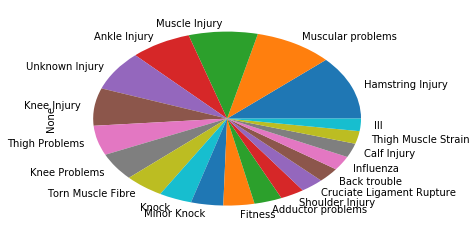

In [158]:
s[:20].plot(kind='pie')

#### Now we saw that the dateframe is ok , let's continue to manage and replace values in our dataframe

In [159]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","[(16/17, Meniscal Injury, 29)]"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","[(18/19, Achilles tendon rupture, 314), (16/17..."
2,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",[]
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","[(18/19, Muscle Injury, 6), (17/18, Minor Knoc..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"[(\nAthletic , \nMan City , 17/18, Jan 30, 201...","[(18/19, Muscle Injury, 12), (16/17, Groin Inj..."


#### currently each row is a player with a list of injuries , we will "flatten" it to get a row per injurie

In [160]:
s = df.apply(lambda x: pd.Series(x['injuries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'injurie'
df = df.drop('injuries', axis=1).join(s)
df.reset_index()
df.head()



,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"


In [161]:
df.shape

(12915, 12)

In [162]:
df = df.reset_index(drop=True)
df.head(10)

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"
5,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(13/14, Torn Muscle Fibre, 10)"
6,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(12/13, Fractured Arm, 53)"
7,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(09/10, Ruptured intraarticular ligament initi..."
8,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",NaN
9,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","(18/19, Muscle Injury, 6)"


#### Need to remove all the player that don't have any injurie history

In [163]:
df = df[df['injurie'].notnull()]
df.shape

(12456, 12)

#### the injurie is currently describe as a tupple , I will create 3 new columns instead of injurie column :
* season of the injurie
* type of the injurie
* recovery time 

In [164]:
df_injurie = pd.DataFrame(df['injurie'].tolist(), index=df.index)
df_injurie.head()

,0,1,2
0,16/17,Meniscal Injury,29
1,18/19,Achilles tendon rupture,314
2,16/17,Disrupted Calf Muscle,57
3,15/16,Calf Injury,17
4,15/16,Torn muscle bundle,24


In [165]:
df = df.drop('injurie', axis=1).join(df_injurie)
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,0,1,2
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",16/17,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",18/19,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",16/17,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Torn muscle bundle,24


In [166]:
df = df.rename(index=str, columns={0: "season", 1: "type" , 2 : "days"})
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",16/17,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",18/19,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",16/17,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Torn muscle bundle,24


#### we will investigate the influence of the age on the injuries ,so, for each row , I add a new column " age " , the age of the player at the specific injurie

In [167]:
import datetime

In [168]:
df.season = df.season.apply(lambda x : '20' + x[3:] + '-01-01')
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24


In [169]:
def injurie_age(season,birth):
    return datetime.datetime.strptime(season, '%Y-%m-%d').year - datetime.datetime.strptime(birth, '%Y-%m-%d').year


In [170]:
df['age'] = df.apply(lambda x : injurie_age(x['season'], x['birth']), axis=1)

In [171]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33


#### we can now start to answer to some questions , we will later manage the others column for further questions

### Questions:

#### Is the age's player has an impact on the injuries ?

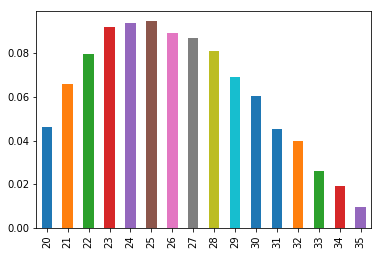

In [172]:
df[(df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',style=None)

#### From the plot we can see , that is difficult to get a response to our question . We see that the player that have the most injuries are player between 23 and 27 years old , the explication is perhaps because this is the high of their carriers the period that they are playing a lot .

#### Still I think that the age has an effect on the injuries of the players, so I selected only the muscle injuries.

#### Let's create a list of muscle injury

In [173]:
muscle_injurie = ['Hamstring Injury','Muscular problems','Muscle Injury','Torn Muscle Fibre',
                  'Adductor problems','Thigh Muscle Strain','Groin Injury','Muscle Fatigue',
                  'Achilles tendon problems','Torn muscle bundle','Biceps femoris muscle injury']

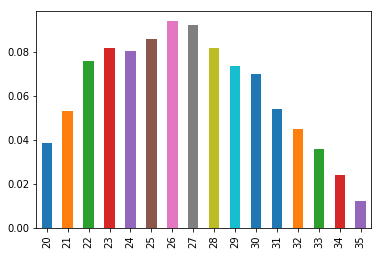

In [174]:
df[(df['type'].isin(muscle_injurie)) & (df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',style=None)

#### we will compare the two plot to see if we can draw conclusions

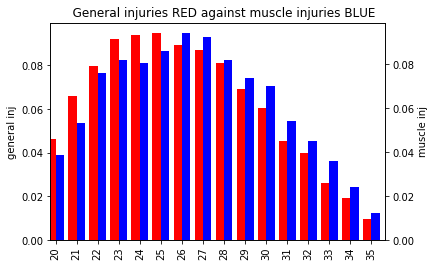

In [175]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax.set_title('   General injuries RED against muscle injuries BLUE')
width = 0.4

df[(df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar', color='red', ax=ax, width=width, position=1)
df[(df['type'].isin(muscle_injurie))
   & (df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('general inj')
ax2.set_ylabel('muscle inj')

plt.show()


#### We see that the muscle injuries  happen later in the carreer when the player is older

#### Let's plot histogram of injurie "ill"

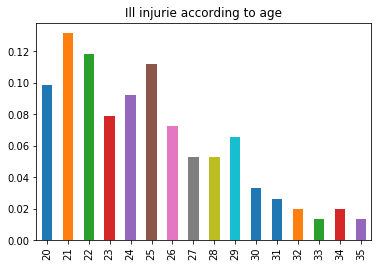

In [176]:
df[(df['type'] == 'Ill') & (df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',style=None,title="Ill injurie according to age")

#### we see that younger are more ill than older , perhaps their lifestyle ? 

## recovery time

### Now I want to analyse the recovery time from an injurie according to player's age
I will take "famous" injurie in football :<br>
* Cruciate Ligament Rupture
* Hamstring Injury
* Ankle Injury


#### To respond we need to group by the specific injurie and get the mean of recovery time.

In [177]:
df.head(100)

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33
5,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2014-01-01,Torn Muscle Fibre,10,31
6,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2013-01-01,Fractured Arm,53,30
7,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2010-01-01,Ruptured intraarticular ligament initiation in...,45,27
9,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2019-01-01,Muscle Injury,6,25
10,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2018-01-01,Minor Knock,4,24


#### need to remove all the rows that dont have recovery time 

In [178]:
df = df[df['days'] != '?']
df["days"] = pd.to_numeric(df["days"])


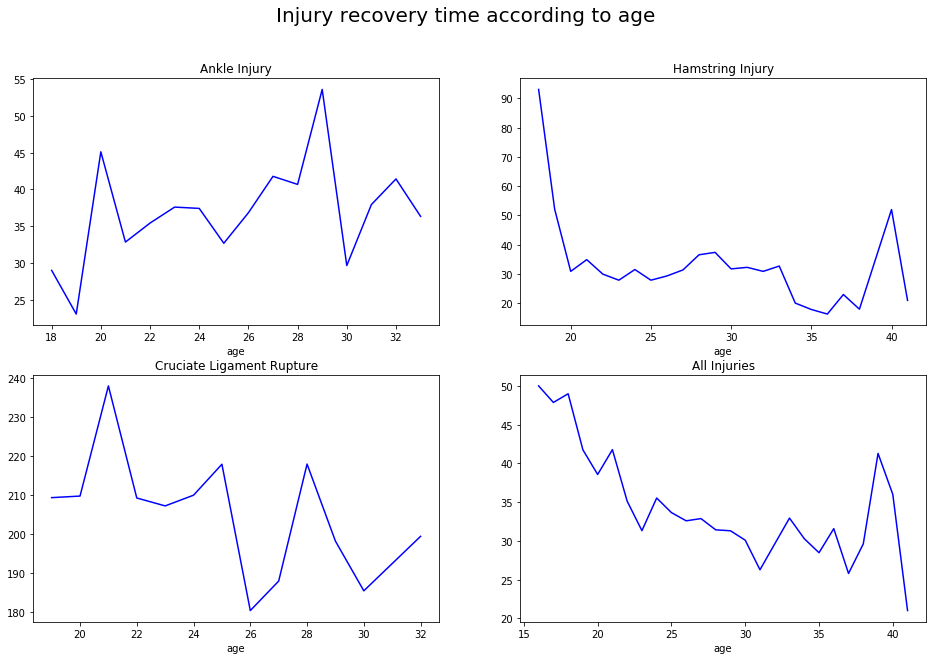

In [179]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
fig.suptitle('Injury recovery time according to age', fontsize=20)
df.groupby('type').get_group('Ankle Injury').groupby('age').filter(lambda x: len(x) > 6).groupby('age')['days'].mean().plot(ax=axes[0,0],title="Ankle Injury",color='blue')
df.groupby('type').get_group('Hamstring Injury').groupby('age').filter(lambda x: len(x) > 0).groupby('age')['days'].mean().plot(ax=axes[0,1],title="Hamstring Injury",color='blue')
df.groupby('type').get_group('Cruciate Ligament Rupture').groupby('age').filter(lambda x: len(x) > 5).groupby('age')['days'].mean().plot(ax=axes[1,0],title="Cruciate Ligament Rupture",color='blue')
df.groupby('age')['days'].mean().plot(ax=axes[1,1],title="All Injuries",color='blue')

#### For the three injuries that we choose we can't draw any conclusion , but when we look to all injuries together we can see that the graph decline with the age .

#### Now we want to see if the famous injury 'Cruciate Ligament Rupture' occurs in olders players

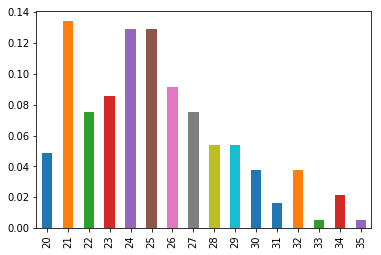

In [180]:
df[(df['type'] == 'Cruciate Ligament Rupture')
   & (df['age'] > 19) & (df['age'] < 36)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',style=None)

#### No we can see that this famous injury occurs more at the young players..

#### What are the 5 inujuries that have the most recovery time ?

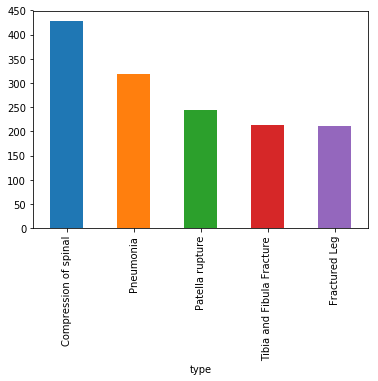

In [181]:
df.groupby('type')['days'].mean().sort_values(ascending=False)[:5].plot(kind='bar')

In [182]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33


#### Now I want to add a column that is the BMI of the players but ype of column are str need to convert it to float 

_Below the function that calculate the BMI (kg/m^2)<br>
definition of BMI : <br>
accepted BMI ranges are underweight: under 18.5 kg/m2, normal weight: 18.5 to 25, overweight: 25 to 30, obese: over 30<br>_


In [183]:
df['height'] = df['height'].str.replace(",",".")
df['height'] = df['height'].str.replace('\\xa0',"").astype(float)

In [184]:
df = df[df['weight'] != '-']
df['weight'] = df['weight'].astype(float)

In [185]:
def define_bmi(height,weight):
    if (weight)/(height*height) > 28:
        return 1
    return 0

In [186]:
df['bmi'] = df.apply(lambda x : define_bmi(x['height'], x['weight']), axis=1)

In [187]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,bmi
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89.0,1.88,Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24,0
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36,0
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34,0
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33,0
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33,0


In [188]:
players_high_bmi = set(df[df['bmi'] == 1].groupby('name').groups.keys())

In [189]:
len(players_high_bmi)

3

In [190]:
players_high_bmi

{'Anthony Ujah', 'Giulio Donati', 'Steven Davis'}

#### There is only three player with a BMI superior to 28 so can't make any analysis there is no enough player to see a correlation between BMI and injuri

### Question:

#### Is the recovery time depends on the club , the player belongs to ? If it's a rich/poor club there will be an incidence? 

#### Let's classify club in categories from poor club to rich club , I don't know yet How many categories it's depends on the distribution

_estimation in millions enough to categorize_

In [191]:
df['club_value'] = df['club_value'].apply(lambda x : x.split(",")[0]).astype(int)

there is club like manchester city that the previous line will return 1 because it's billions and not millions so need to return it to 1000 millions

In [192]:
df['club_value'] = df['club_value'].apply(lambda x : 1000 if x == 1 else x).astype(int)

In [193]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,bmi
0,238223,Ederson,Manchester City,1000,1993-08-17,89.0,1.88,Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24,0
1,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36,0
2,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34,0
3,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33,0
4,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33,0


Let's see the distribution to know how to categorize in equal sets

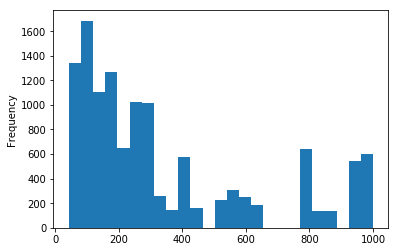

In [194]:
df['club_value'].plot(kind='hist',bins=25)

#### We can see that most of the club are under 320 millions

#### We want to divide our data frame in 6 equals sets , we have about ~12000 injuries , so each group get 2000 injuries

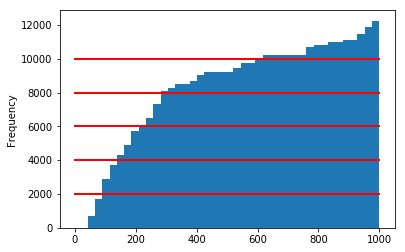

In [195]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111)
df['club_value'].plot(kind='hist',bins=40,cumulative=True,ax=ax)
plt.plot([0,1000], [2000,2000], 'r-', lw=2)
plt.plot([0,1000], [4000,4000], 'r-', lw=2)
plt.plot([0,1000], [6000,6000], 'r-', lw=2)
plt.plot([0,1000], [8000,8000], 'r-', lw=2)
plt.plot([0,1000], [10000,10000], 'r-', lw=2)


#### So we will separate the club by 6 categories :
* [0-75] millions : 1 
* [75-125] millions : 2 
* [125 -225] millions : 3
* [225 -275] millions : 4
* [275 -600] millions : 5
* [600 -1000] millions : 6

In [196]:
def club_to_category(value):
    if 0 < value <=  75 :
        return 1
    if 75 < value <= 125 :
        return 2
    if 125 < value <= 225 :
        return 3
    if 225 < value <= 275 :
        return 4
    if 275 < value <= 600 :
        return 5
    else :
        return 6  

In [197]:
df['club_value'] = df['club_value'].apply(club_to_category)

In [198]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,bmi
0,238223,Ederson,Manchester City,6,1993-08-17,89.0,1.88,Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24,0
1,40423,Claudio Bravo,Manchester City,6,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36,0
2,40423,Claudio Bravo,Manchester City,6,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34,0
3,40423,Claudio Bravo,Manchester City,6,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33,0
4,40423,Claudio Bravo,Manchester City,6,1983-04-13,84.0,1.84,Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33,0


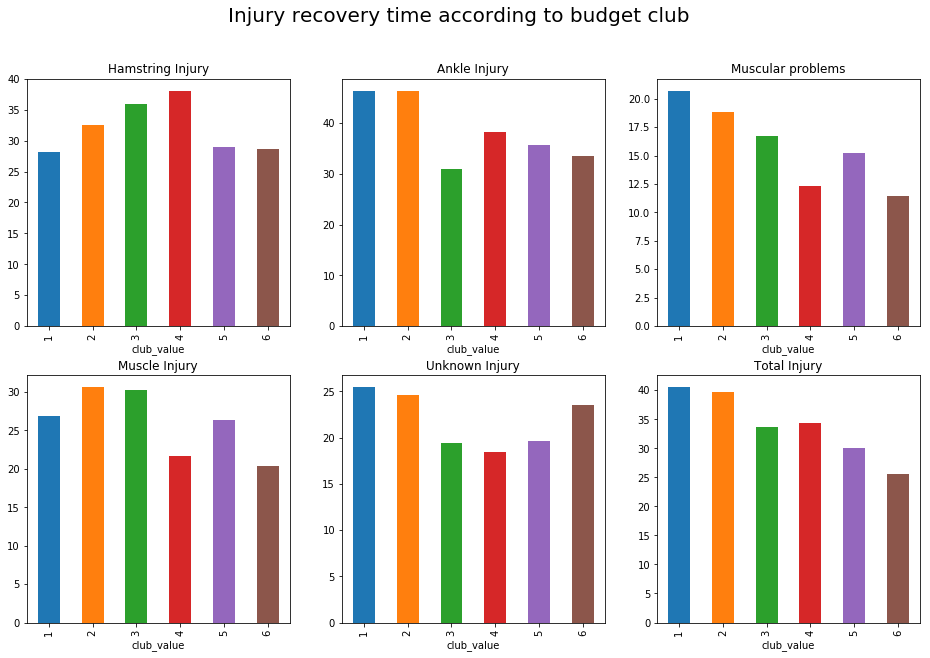

In [199]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
fig.suptitle('Injury recovery time according to budget club', fontsize=20)
df.groupby('type').get_group('Hamstring Injury').groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[0,0],title="Hamstring Injury")
df.groupby('type').get_group('Ankle Injury').groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[0,1],title="Ankle Injury")
df.groupby('type').get_group('Muscular problems').groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[0,2],title="Muscular problems")
df.groupby('type').get_group('Muscle Injury').groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[1,0],title="Muscle Injury")
df.groupby('type').get_group('Unknown Injury').groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[1,1],title="Unknown Injury")
df.groupby('club_value').mean()['days'].plot(kind='bar',ax=axes[1,2],title="Total Injury")

#### We can see that money helps to recover faster after an injury ... We can see that for "Total Injury" in average if you are a player of a top club you will recover 15 days before a player of a bottom club , it's a huge difference ! 